# 🏥 Clinical Notes Disease Prediction with Explainability
This notebook builds a pipeline to predict diseases from clinical notes using:
- Logistic Regression + TF-IDF (baseline)
- BioClinicalBERT (advanced)
- Explainability with LIME, SHAP, and attention heatmaps
- Interactive dashboard with Gradio

In [1]:
# 📦 Install dependencies
!pip install transformers datasets lime shap gradio scikit-learn wordcloud matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=19eecd91811a8de6ba922c2b401ee3fde51f279dd3aca810b0d66a27568deaf6
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
# 📚 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_text import LimeTextExplainer
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import gradio as gr


In [4]:
# 📂 Load dataset (upload CSV manually in Colab or mount Drive)
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
print("Columns:", df.columns)
df.head()


Saving mtsamples.csv to mtsamples.csv
Columns: Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
# 🧹 Preprocessing
# Try to detect text and label columns automatically
possible_text = ["text_clean","transcription","notes","report","text"]
possible_label = ["label","disease","diagnosis","category"]
text_col, label_col = None, None

for col in possible_text:
    if col in df.columns: text_col = col; break

# Explicitly set label_col to 'medical_specialty' as it exists in the dataframe
label_col = 'medical_specialty'

print("Using:", text_col, "(text),", label_col, "(label)")

df[text_col] = df[text_col].str.lower().str.replace(r"[^a-z0-9 ]"," ",regex=True)
df[label_col] = df[label_col].astype(str)
df.head()

Using: transcription (text), medical_specialty (label)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,subjective this 23 year old white female pr...,"allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history he has difficulty climb...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,history of present illness i have seen abc ...,"bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,2 d m mode 1 left atrial enlargement wit...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1 the left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


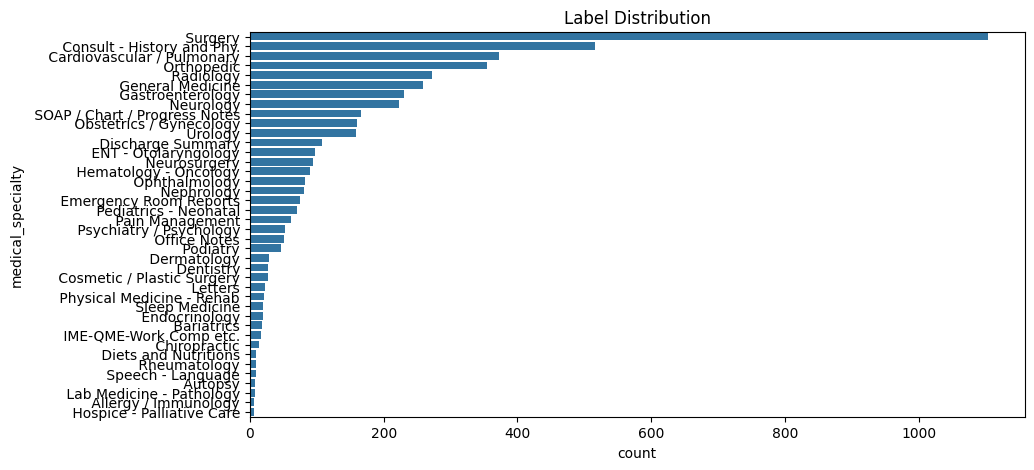

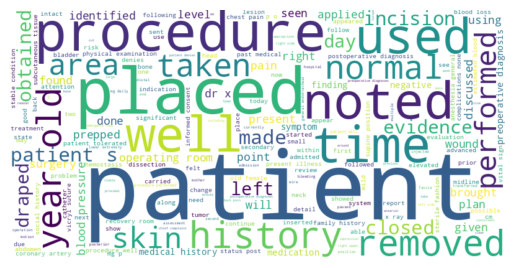

In [6]:
# 📊 Exploratory Data Analysis
plt.figure(figsize=(10,5))
sns.countplot(y=df[label_col], order=df[label_col].value_counts().index)
plt.title("Label Distribution")
plt.show()

# Drop rows with missing values in the text column before generating the word cloud
df_cleaned = df.dropna(subset=[text_col])
text_all = " ".join(df_cleaned[text_col].tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_all)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Classification Report:
                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         2
                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       0.28      0.24      0.26        79
                  Chiropractic       0.00      0.00      0.00         2
    Consult - History and Phy.       0.34      0.72      0.46       111
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         7
                     Dentistry       0.00      0.00      0.00         8
                   Dermatology       0.00      0.00      0.00         2
          Diets and Nutritions       0.00      0.00      0.00         1
             Discharge Summary       0.35      0.30      0.33        23
          ENT - Otolaryngology       0.00      0.00      0.00        32
        Emergency Room Reports       0.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


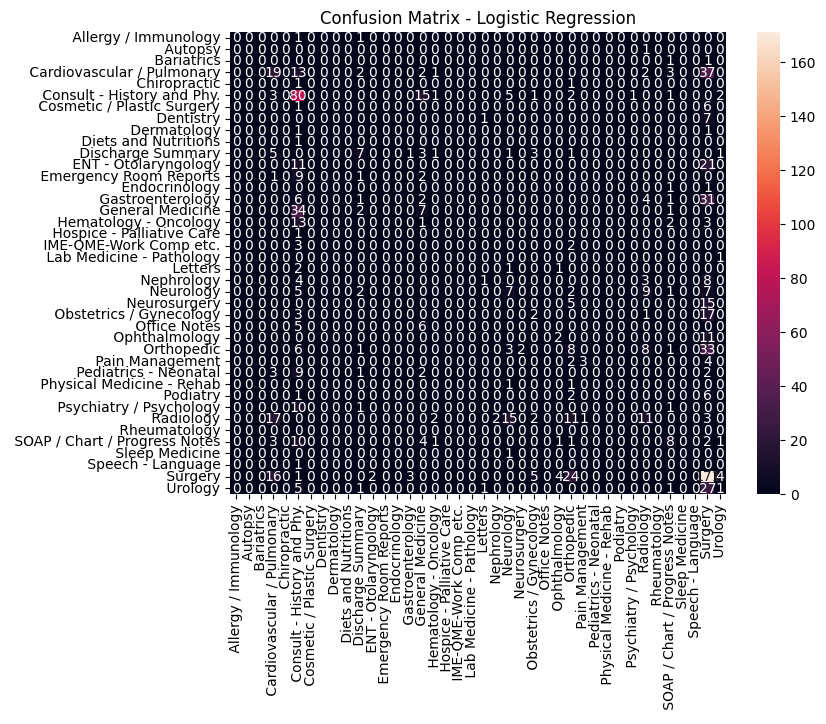

In [7]:
# ⚡ Baseline: TF-IDF + Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(df_cleaned[text_col], df_cleaned[label_col], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [8]:
# 🔍 Explainability with LIME on baseline
class_names = list(df[label_col].unique())
explainer = LimeTextExplainer(class_names=class_names)
idx = 0
# Apply the vectorizer to the single instance before prediction
exp = explainer.explain_instance(X_test.iloc[idx], lambda x: clf.predict_proba(vectorizer.transform(x)), num_features=10)
exp.show_in_notebook(text=True)

In [9]:
# 🤖 BioClinicalBERT setup
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = len(df[label_col].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

def tokenize(batch):
    texts = [str(t) for t in batch[text_col]]  # make sure they’re plain strings
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

# Split data and convert to Hugging Face Dataset
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Encode labels - fit on combined labels, then transform
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df[label_col], test_df[label_col]])
label_encoder.fit(all_labels)

train_dataset = train_dataset.map(lambda x: {"labels": label_encoder.transform([x[label_col]])[0]}, batched=False)
test_dataset = test_dataset.map(lambda x: {"labels": label_encoder.transform([x[label_col]])[0]}, batched=False)

# Tokenize datasets
train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Define id2label for later use
id2label = {i: l for i, l in enumerate(label_encoder.classes_)}

Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/994 [00:00<?, ? examples/s]

Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/994 [00:00<?, ? examples/s]

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized, # Use the tokenized training dataset
    eval_dataset=test_tokenized # Use the tokenized testing dataset
)

trainer.train()
trainer.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,2.142200,2.004593


{'eval_loss': 2.0045928955078125,
 'eval_runtime': 32.3059,
 'eval_samples_per_second': 30.768,
 'eval_steps_per_second': 7.708,
 'epoch': 1.0}

In [23]:
import gradio as gr
import torch

# Make sure id2label is defined from your LabelEncoder
# id2label = {i: l for i, l in enumerate(label_encoder.classes_)}

def predict_and_explain(note: str):
    try:
        # Ensure text is string
        note = str(note)

        # Tokenize input
        inputs = tokenizer(
            note,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

        # Get prediction
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        label = id2label[pred]

        # Return a clean string
        return f"🩺 Predicted disease/diagnosis: {label}"

    except Exception as e:
        return f"⚠️ Error: {str(e)}"

# Gradio UI
demo = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Textbox(lines=6, placeholder="Enter clinical note here..."),
    outputs="text",
    title="Clinical Notes Disease Prediction",
    description="Enter a clinical note and get a predicted disease/diagnosis"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b59440df0184285d2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
